In [207]:
import json
import pickle
import time
from datetime import datetime, timedelta
from itertools import product

import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import joblib
import os

import matplotlib.pyplot as plt
from tqdm import tqdm

# Local modules
import modularised_utils as mut
import opt_utils as oput
import evaluation_utils as evut
import Linear_Additive_Noise_Models as lanm
import operations as ops
import params
import random

np.random.seed(0)

In [235]:
experiment = 'synth1'

In [236]:
T_results_emp = joblib.load(f"data/{experiment}/diroca_train_results_empirical.pkl")

In [237]:
coeff_estimation = False

Dll_obs = joblib.load(f"data/{experiment}/Dll_obs_test.pkl")
Dhl_obs =  joblib.load(f"data/{experiment}/Dhl_obs_test.pkl")

LLmodels = joblib.load(f"data/{experiment}/LLmodels.pkl")
HLmodels = joblib.load(f"data/{experiment}/HLmodels.pkl")

num_llsamples, num_hlsamples  = Dll_obs.shape[0], Dhl_obs.shape[0]

Gll, Ill = mut.load_model(experiment, 'LL')
Ghl, Ihl = mut.load_model(experiment, 'HL')

n_varsll, n_varshl = len(Gll.nodes()), len(Ghl.nodes())

omega    = mut.load_omega_map(experiment)

if coeff_estimation == True:
    ll_coeffs = mut.get_coefficients(Dll_obs, Gll)
    hl_coeffs = mut.get_coefficients(Dhl_obs, Ghl) 
else:
    ll_coeffs = mut.load_coeffs(experiment, 'LL')
    hl_coeffs = mut.load_coeffs(experiment, 'HL')

U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)

data = evut.generate_empirical_data(LLmodels, HLmodels, omega, U_ll_hat, U_hl_hat)

In [238]:
test_observ        = True
test_interv        = True 
metric             = 'fro'
num_iter           = 20

if test_observ and test_interv:
    test_data = data

elif test_observ:
    test_data = {None: data[None]}

elif test_interv:
    test_data = {k: v for k, v in data.items() if k is not None}

## test theorem

requires coeff_estimation = True

In [239]:
if coeff_estimation == True:
    results_single = {method: {'errors': [], 'mean': 0, 'ci': 0} for method in T_results_emp.keys()}

    for name, method_data in T_results_emp.items():
        T = method_data['T_matrix']
        errors = []  # Store errors for each intervention
        scale_factor = 1/np.sqrt(len(Ill))

        for iota in Ill:
            L_i = LLmodels[iota].F
            H_i = HLmodels[omega[iota]].F

            D_l = L_i @ U_ll_hat.T
            D_h = H_i @ U_hl_hat.T
            
            base_norm = D_l#/ np.linalg.norm(D_l, 'fro')
            abst_norm = D_h#/ np.linalg.norm(D_h, 'fro')
            
            tau_base = T @ base_norm
            dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
            errors.append(dist)  # Store individual errors

        # Calculate mean and CI
        mean_error = np.mean(errors)
        std_error = np.std(errors)
        ci = std_error

        # Store all statistics
        results_single[name] = {
            'errors': errors,
            'mean': mean_error,
            'ci': ci
        }

    max_mean = max(v['mean'] for v in results_single.values())
    scale_factor = 1/max_mean

    # Sort by mean error
    results_single = dict(sorted(results_single.items(), key=lambda x: x[1]['mean']))

    # Print results
    print("\n" + "="*100)
    print(f"{'Method':<15} {'Error (mean ± CI)':<35}")
    print("="*100)

    for method, stats in results_single.items():
        print(f"{method:<15} {stats['mean']:>8.4f} ± {stats['ci']:<8.4f}")

else:
    print('No coeff estimation')

No coeff estimation


In [240]:
rad_values = np.arange(0.05, 16.05, 1).tolist()  
sample_forms = ['boundary', 'sample']

hat_dict = {'L': U_ll_hat, 'H': U_hl_hat}

worst = 'T_8'
U_worst_L = T_results_emp[worst]['optimization_params']['L']['pert_U']
U_worst_H = T_results_emp[worst]['optimization_params']['H']['pert_U']


target_samplesL = U_ll_hat.shape[0]
target_samplesH = U_hl_hat.shape[0]

indicesL = np.random.choice(U_worst_L.shape[0], size=target_samplesL, replace=False)
indicesH = np.random.choice(U_worst_H.shape[0], size=target_samplesH, replace=False)

U_worst_L = U_worst_L[indicesL]
U_worst_H = U_worst_H[indicesH]

worst_dict = {'L': U_worst_L, 'H': U_worst_H}

center = 'worst'
if center == 'hat':
    center_matrix = hat_dict
elif center == 'worst':
    center_matrix = worst_dict

coverage_type='uniform'

In [200]:
# # Initialize results structure
# results = {rad: {
#     sample_form: {
#         'empirical': {method: [] for method in T_results_emp.keys()}
#     } for sample_form in sample_forms
# } for rad in rad_values}

# for rad in tqdm(rad_values):
#     for sample_form in sample_forms:
#         for iter_num in range(10):
#             pert_L = evut.generate_perturbation_matrix(rad, sample_form, 'L', hat_dict, coverage = coverage_type)
#             pert_H = evut.generate_perturbation_matrix(rad, sample_form, 'H', hat_dict, coverage = coverage_type)
            
#             for name, method_data in T_results_emp.items():
#                 T = method_data['T_matrix']
#                 total = 0
#                 for iota in Ill:
#                     L_i = LLmodels[iota].F
#                     H_i = HLmodels[omega[iota]].F

#                     pert_noise_L = center_matrix['L'].T + pert_L.T
#                     pert_noise_H = center_matrix['H'].T + pert_H.T

#                     base_norm = L_i @ pert_noise_L
#                     abst_norm = H_i @ pert_noise_H
                    
#                     tau_base = T @ base_norm
#                     dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
#                     total += dist
                
#                 iter_avg = total / len(Ill)
#                 results[rad][sample_form]['empirical'][name].append(iter_avg)


# # Print results
# print("\n" + "="*100)
# print(f"{'Radius':<8} {'Sample Form':<12} {'Method':<15} {'Error (mean ± CI)':<35}")
# print("="*100)

# for rad in rad_values:
#     for sample_form in sample_forms:
#         print(f"\nRadius: {rad}, Sample form: {sample_form}")
#         print("-"*100)
        
#         # Create dictionary of method statistics
#         method_stats = {}
#         for method in T_results_emp.keys():
#             errors = results[rad][sample_form]['empirical'][method]
#             error_mean = np.mean(errors)
#             error_std = np.std(errors)
#             ci = 1.96 * error_std
#             method_stats[method] = (error_mean, ci)
        
#         # Sort methods by mean error (descending order for worst to best)
#         sorted_methods = sorted(method_stats.items(), key=lambda x: x[1][0], reverse=True)
        
#         # Print sorted results
#         for method, (error_mean, ci) in sorted_methods:
#             print(f"{rad:<8} {sample_form:<12} {method:<15} "
#                   f"{error_mean:>8.4f} ± {ci:<8.4f}")

# # Find best methods (already sorted, just take last one)
# for rad in rad_values:
#     for sample_form in sample_forms:
#         print(f"\nRanking for radius {rad}, {sample_form} sampling (worst to best):")
        
#         error_means = {method: np.mean(results[rad][sample_form]['empirical'][method])
#                       for method in T_results_emp.keys()}
        
#         # Sort by error value (descending)
#         sorted_methods = sorted(error_means.items(), key=lambda x: x[1], reverse=True)
        
#         # Print all methods with ranking
#         for rank, (method, error) in enumerate(sorted_methods, 1):
#             print(f"{rank}. {method:<15} (error: {error:.4f})")
    

In [132]:
# # Example usage with epsilon-delta methods
# methods_to_plot = list(T_results_emp.keys())
# evut.plot_empirical_abstraction_error(results, methods_to_plot, 'boundary')
# evut.plot_empirical_abstraction_error(results, methods_to_plot, 'sample')

### a. Familly of Pertubations

In [133]:
# Generate perturbation families
pert_family_L = evut.generate_perturbation_family(
    np.zeros_like(hat_dict['L']),
    k=100,  
    r_mu=0.0,
    r_sigma=1.0,
    coverage=coverage_type
)

pert_family_H = evut.generate_perturbation_family(
    np.zeros_like(hat_dict['H']),
    k=100,
    r_mu=0.0,
    r_sigma=1.0,
    coverage=coverage_type
)

In [134]:
results = {
    sample_form: {
        'empirical': {method: [] for method in T_results_emp.keys()}
    } for sample_form in sample_forms
}

for pert_L, pert_H in zip(pert_family_L, pert_family_H):
    for sample_form in sample_forms:
        for name, method_data in T_results_emp.items():
            T = method_data['T_matrix']
            
            distances = []
            
            for iota in Ill:
                L_i = LLmodels[iota].F
                H_i = HLmodels[omega[iota]].F
                
                pert_noise_L = center_matrix['L'].T + pert_L.T
                pert_noise_H = center_matrix['H'].T + pert_H.T
                
                base_norm = L_i @ pert_noise_L
                abst_norm = H_i @ pert_noise_H
                
                tau_base = T @ base_norm
                dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                distances.append(dist)
            
            results[sample_form]['empirical'][name].extend(distances)

In [135]:
# Print results with ranking
print("\n" + "="*100)
print(f"{'Rank':<5} {'Method':<15} {'Empirical Distance (mean ± CI)':<35}")
print("="*100)

for sample_form in sample_forms:
    print(f"\nSample form: {sample_form}")
    print("-"*100)
    
    # Calculate means and stds for all methods
    method_stats = {}
    for method in T_results_emp.keys():
        distances = results[sample_form]['empirical'][method]
        mean = np.mean(distances)
        std = np.std(distances)
        method_stats[method] = (mean, std)
    
    # Sort methods by mean error (worst to best)
    sorted_methods = sorted(method_stats.items(), key=lambda x: x[1][0], reverse=True)
    
    # Print ranked results
    for rank, (method, (mean, std)) in enumerate(sorted_methods, 1):
        print(f"{rank:<5} {method:<15} "
              f"{mean:>8.4f} ± {std/10:<8.4f}")

print("="*100)

# Print summary of best and worst methods
for sample_form in sample_forms:
    print(f"\nSummary for {sample_form} sampling:")
    print("-"*100)
    
    # Get sorted methods
    method_stats = {method: (np.mean(results[sample_form]['empirical'][method]),
                           np.std(results[sample_form]['empirical'][method]))
                   for method in T_results_emp.keys()}
    sorted_methods = sorted(method_stats.items(), key=lambda x: x[1][0], reverse=True)
    
    # Print worst and best
    worst_method, (worst_error, worst_std) = sorted_methods[0]
    best_method, (best_error, best_std) = sorted_methods[-1]


Rank  Method          Empirical Distance (mean ± CI)     

Sample form: boundary
----------------------------------------------------------------------------------------------------
1     T_pa            365.7458 ± 1.2376  
2     T_0.046-0.01    354.6764 ± 1.8642  
3     T_na            346.0597 ± 1.3080  
4     T_s             306.4705 ± 0.8978  
5     T_b             239.1910 ± 0.0156  
6     T_1             222.9706 ± 0.1587  
7     T_0.00          216.5727 ± 0.0595  
8     T_8             201.8657 ± 0.1405  
9     T_2             201.8657 ± 0.1405  
10    T_4             201.8657 ± 0.1405  

Sample form: sample
----------------------------------------------------------------------------------------------------
1     T_pa            365.7458 ± 1.2376  
2     T_0.046-0.01    354.6764 ± 1.8642  
3     T_na            346.0597 ± 1.3080  
4     T_s             306.4705 ± 0.8978  
5     T_b             239.1910 ± 0.0156  
6     T_1             222.9706 ± 0.1587  
7     T_0.00          2

In [150]:
def compute_errors(
    T_results_emp,
    Ill_relevant,
    LLmodels,
    HLmodels,
    omega,
    base_noise_L,
    base_noise_H,
    shift=False,
    r_mu=0.0,
    r_sigma=0.0,
    num_perturbations=1,
    coverage_type='uniform'
):

    if shift:
        pert_family_L = evut.generate_perturbation_family(
            np.zeros_like(base_noise_L),
            k=num_perturbations,
            r_mu=r_mu,
            r_sigma=r_sigma,
            coverage=coverage_type
        )
        pert_family_H = evut.generate_perturbation_family(
            np.zeros_like(base_noise_H),
            k=num_perturbations,
            r_mu=r_mu,
            r_sigma=r_sigma,
            coverage=coverage_type
        )
    else:
        # No perturbations, only one "fake" no-perturbation
        pert_family_L = [np.zeros_like(base_noise_L)]
        pert_family_H = [np.zeros_like(base_noise_H)]
        num_perturbations = 1  # force to 1

    # Initialize result dictionary
    results = {method: [] for method in T_results_emp.keys()}

    # Loop over perturbations (only one if shift=False)
    for pert_L, pert_H in zip(pert_family_L, pert_family_H):

        for method_name, method_data in T_results_emp.items():
            T = method_data['T_matrix']
            distances = []
                
            for iota in Ill:
                L_i = LLmodels[iota].F
                H_i = HLmodels[omega[iota]].F
                
                pert_noise_L = center_matrix['L'].T + pert_L.T
                pert_noise_H = center_matrix['H'].T + pert_H.T
                
                base_norm = L_i @ pert_noise_L
                abst_norm = H_i @ pert_noise_H
                
                tau_base = T @ base_norm
                dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                distances.append(dist)

            results[method_name].extend(distances)

    return results

In [161]:
ci_across_sigmas = {method: [] for method in methods_to_track}

# Inside your r_sigma loop:
for method in methods_to_track:
    mean = np.mean(results[method])
    std = np.std(results[method])
    ci = std
    ci_across_sigmas[method].append(ci)

In [183]:
def compute_errors(
    T_results_emp,
    Ill_relevant,
    LLmodels,
    HLmodels,
    omega,
    base_noise_L,
    base_noise_H,
    shift=False,
    r_mu=0.0,
    r_sigma=0.0,
    num_perturbations=1,
    coverage_type='uniform'
):
    import numpy as np

    if shift:
        pert_family_L = evut.generate_perturbation_family(
            np.zeros_like(base_noise_L),
            k=num_perturbations,
            r_mu=r_mu,
            r_sigma=r_sigma,
            coverage=coverage_type
        )
        pert_family_H = evut.generate_perturbation_family(
            np.zeros_like(base_noise_H),
            k=num_perturbations,
            r_mu=r_mu,
            r_sigma=r_sigma,
            coverage=coverage_type
        )
    else:
        # No perturbations, only one "fake" no-perturbation
        pert_family_L = [np.zeros_like(base_noise_L)]
        pert_family_H = [np.zeros_like(base_noise_H)]
        num_perturbations = 1  # force to 1

    # Initialize result dictionary
    results = {method: [] for method in T_results_emp.keys()}

    # Loop over perturbations (only one if shift=False)
    for pert_L, pert_H in zip(pert_family_L, pert_family_H):
        for method_name, method_data in T_results_emp.items():
            T = method_data['T_matrix']
            distances = []
            for iota in Ill_relevant:
                L_i = LLmodels[iota].F
                H_i = HLmodels[omega[iota]].F

                pert_noise_L = base_noise_L.T + pert_L.T
                pert_noise_H = base_noise_H.T + pert_H.T

                base_norm = L_i @ pert_noise_L
                abst_norm = H_i @ pert_noise_H

                tau_base = T @ base_norm
                dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                distances.append(dist)

            results[method_name].extend(distances)

    # Compute mean and CI for each method
    stats = {}
    for method, vals in results.items():
        vals = np.array(vals)
        mean = np.mean(vals)
        std = np.std(vals)
        ci = std
        stats[method] = {'mean': mean, 'ci': ci, 'all': vals}

    return results, stats

In [245]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'text.usetex': False,  # REMOVE or COMMENT THIS LINE!
    'font.family': 'serif',
    'font.size': 16,
    # ... other settings ...
})

# Define the values to test for sigma (keeping mu fixed at 0)
sigma_values = np.linspace(0, 1000, 20)
mu_fixed = 0

# Initialize results dictionary with only the methods we want to track
methods_to_track = ['T_8', 'T_pa', 'T_na', 'T_b', 'T_s', 'T_0.00']
error_evolution_slc = {method: [] for method in methods_to_track}
std_evolution_slc = {method: [] for method in methods_to_track}

# Test each sigma value
for sigma in sigma_values:
    # Compute errors with current parameters
    results_slc, stats_slc = compute_errors(
        T_results_emp=T_results_emp,
        Ill_relevant=Ill,
        LLmodels=LLmodels,
        HLmodels=HLmodels,
        omega=omega,
        base_noise_L=center_matrix['L'],
        base_noise_H=center_matrix['H'],
        shift=True,
        r_mu=mu_fixed,
        r_sigma=sigma,
        num_perturbations=1,
        coverage_type='rand'
    )
    
    # Store mean and std errors for each method
    for method in methods_to_track:
        vals = np.array(results_slc[method])
        error_evolution_slc[method].append(np.mean(vals))
        std_evolution_slc[method].append(np.std(vals))

In [221]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'text.usetex': False,  # REMOVE or COMMENT THIS LINE!
    'font.family': 'serif',
    'font.size': 16,
    # ... other settings ...
})

# Define the values to test for sigma (keeping mu fixed at 0)
sigma_values = np.linspace(0, 1000, 20)
mu_fixed = 0

# Initialize results dictionary with only the methods we want to track
methods_to_track = ['T_8', 'T_pa', 'T_na', 'T_b', 'T_s', 'T_0.00']
error_evolution_luc = {method: [] for method in methods_to_track}
std_evolution_luc = {method: [] for method in methods_to_track}

# Test each sigma value
for sigma in sigma_values:
    # Compute errors with current parameters
    results_luc, stats_luc = compute_errors(
        T_results_emp=T_results_emp,
        Ill_relevant=Ill,
        LLmodels=LLmodels,
        HLmodels=HLmodels,
        omega=omega,
        base_noise_L=center_matrix['L'],
        base_noise_H=center_matrix['H'],
        shift=True,
        r_mu=mu_fixed,
        r_sigma=sigma,
        num_perturbations=1,
        coverage_type='rand'
    )
    
    # Store mean and std errors for each method
    for method in methods_to_track:
        vals = np.array(results_luc[method])
        error_evolution_luc[method].append(np.mean(vals))
        std_evolution_luc[method].append(np.std(vals))

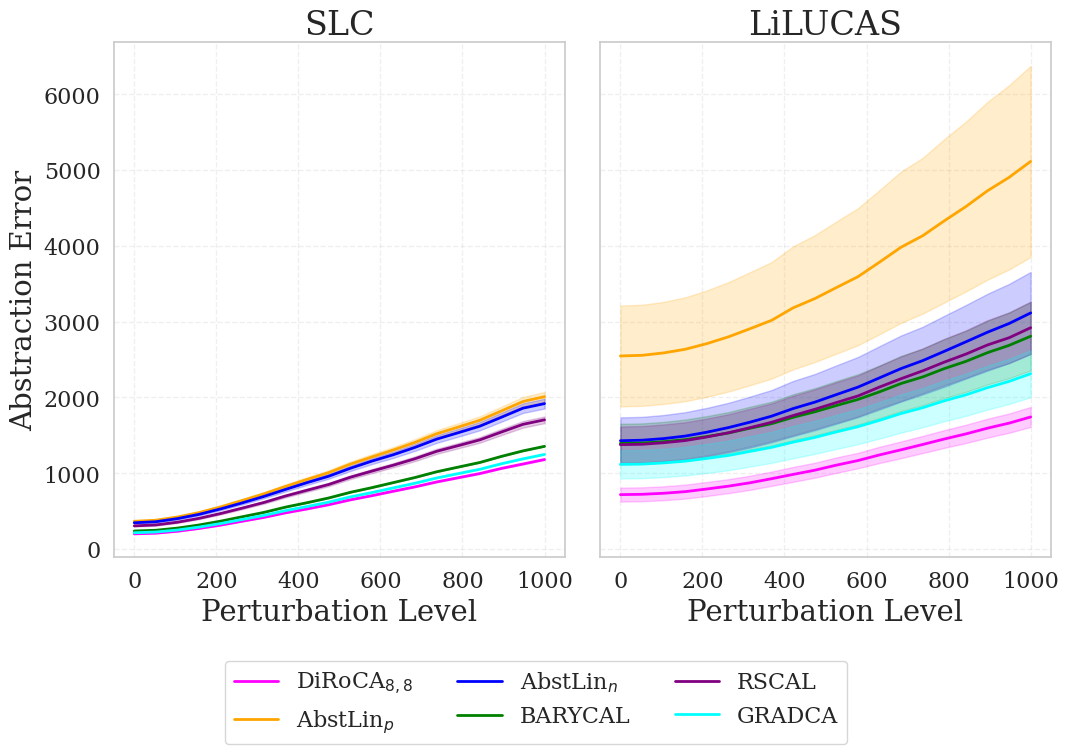

In [258]:
import numpy as np
import matplotlib.pyplot as plt

error_evolution_1 = error_evolution_slc
std_evolution_1 = std_evolution_slc
error_evolution_2 = error_evolution_luc
std_evolution_2 = std_evolution_luc
# Define method labels and styles (LaTeX for legend)
method_labels = {
    'T_pa': (r'AbstLin$_{p}$', 'orange', 'o'),
    'T_na': (r'AbstLin$_{n}$', 'blue', 's'),
    'T_b': (r'BARYCAL', 'green', '^'),
    'T_s': (r'RSCAL', 'purple', 'v'),
    'T_0.00': (r'GRADCA', 'cyan', 'D'),
    'T_1': (r'DiRoCA$_{1,1}$', 'brown', 'p'),
    'T_2': (r'DiRoCA$_{2,2}$', 'pink', 'h'),
    'T_4': (r'DiRoCA$_{4,4}$', 'gray', '8'),
    'T_8': (r'DiRoCA$_{8,8}$', 'magenta', '*'),
    'T_30': (r'DiRoCA$_{30,30}$', 'cyan', 'P'),
    'T_100': (r'DiRoCA$_{100,100}$', 'magenta', 'X'),
    'T_1000': (r'DiRoCA$_{1000,1000}$', 'teal', 'd'),
    'T_0.046-0.01': (r'DiRoCA$_{\epsilon\ell^*,\epsilon h^*}$', 'black', 'H')
}

fig, axes = plt.subplots(1, 2, figsize=(11, 7), sharey=True)

# First subplot
ax1 = axes[0]
for method in methods_to_track:
    style = method_labels.get(method, (method, 'black', 'o'))
    means = np.array(error_evolution_1[method])
    for mean in means:
        mean = mean**2
    stds = np.array(std_evolution_1[method])
    # ax1.plot(
    #     sigma_values, means,
    #     marker=style[2], label=style[0], color=style[1],
    #     linewidth=2, markersize=8, markeredgecolor='black', markeredgewidth=1
    # )
    ax1.plot(
    sigma_values, means,
    label=style[0], color=style[1],
    linewidth=2
)
    ax1.fill_between(
        sigma_values, means - stds, means + stds,
        color=style[1], alpha=0.2
    )
ax1.set_xlabel('Perturbation Level', fontsize=21)
ax1.set_ylabel('Abstraction Error', fontsize=21)
ax1.set_title('SLC', fontsize=24)
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.tick_params(axis='both', labelsize=16)
# ax1.set_facecolor('#f8f8f8')
ax1.set_facecolor('white')
#   
# Second subplot
ax2 = axes[1]
for method in methods_to_track:
    style = method_labels.get(method, (method, 'black', 'o'))
    means = np.array(error_evolution_2[method])
    stds = np.array(std_evolution_2[method])
    # ax2.plot(
    #     sigma_values, means,
    #     marker=style[2], label=style[0], color=style[1],
    #     linewidth=2, markersize=8, markeredgecolor='black', markeredgewidth=1
    # )
    ax2.plot(
    sigma_values, means,
    label=style[0], color=style[1],
    linewidth=2
)
    ax2.fill_between(
        sigma_values, means - stds, means + stds,
        color=style[1], alpha=0.2
    )
ax2.set_xlabel('Perturbation Level', fontsize=21)
ax2.set_title('LiLUCAS', fontsize=24)
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.tick_params(axis='both', labelsize=16)
# ax2.set_facecolor('#f8f8f8')
ax2.set_facecolor('white')

# Create a single legend below both plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center', bbox_to_anchor=(0.5, -0.1),
    ncol=3, frameon=True, fontsize=16
)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space for legend
plt.show()

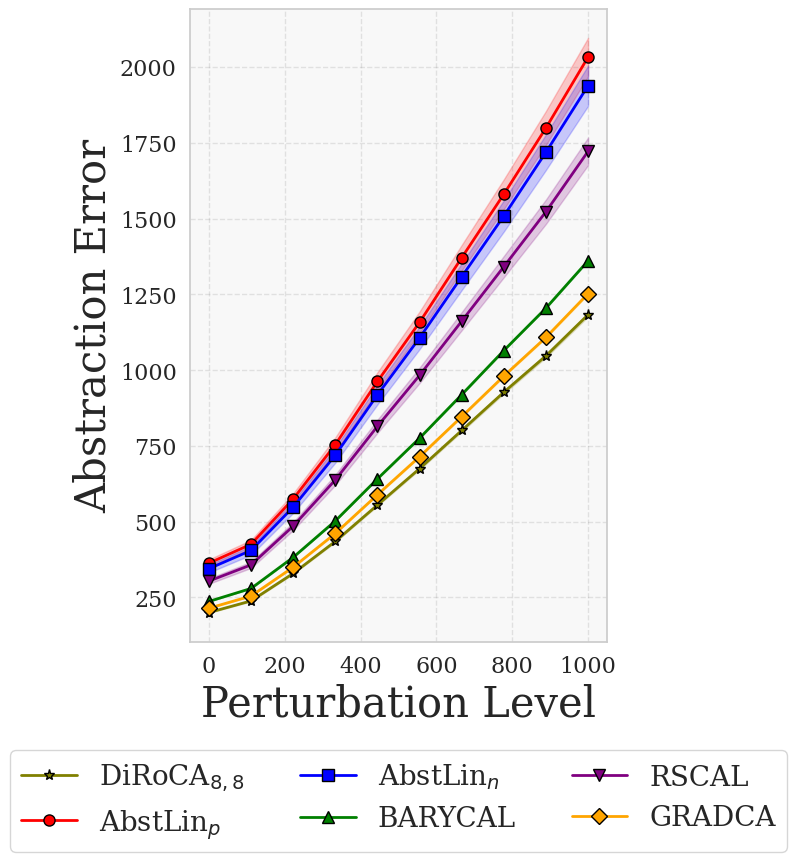

In [206]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'text.usetex': False,  # REMOVE or COMMENT THIS LINE!
    'font.family': 'serif',
    'font.size': 16,
    # ... other settings ...
})

# Define the values to test for sigma (keeping mu fixed at 0)
sigma_values = np.linspace(0, 1000, 10)
mu_fixed = 0

# Initialize results dictionary with only the methods we want to track
methods_to_track = ['T_8', 'T_pa', 'T_na', 'T_b', 'T_s', 'T_0.00']
error_evolution = {method: [] for method in methods_to_track}
std_evolution = {method: [] for method in methods_to_track}

# Test each sigma value
for sigma in sigma_values:
    # Compute errors with current parameters
    results, stats = compute_errors(
        T_results_emp=T_results_emp,
        Ill_relevant=Ill,
        LLmodels=LLmodels,
        HLmodels=HLmodels,
        omega=omega,
        base_noise_L=center_matrix['L'],
        base_noise_H=center_matrix['H'],
        shift=True,
        r_mu=mu_fixed,
        r_sigma=sigma,
        num_perturbations=1,
        coverage_type='rand'
    )
    
    # Store mean and std errors for each method
    for method in methods_to_track:
        vals = np.array(results[method])
        error_evolution[method].append(np.mean(vals))
        std_evolution[method].append(np.std(vals))

# Create the plot
fig, ax = plt.subplots(figsize=(7, 9))

# Define method labels and styles
method_labels = {
    'T_pa': (r'AbstLin$_{p}$', 'red', 'o'),
    'T_na': (r'AbstLin$_{n}$', 'blue', 's'),
    'T_b': (r'BARYCAL', 'green', '^'),
    'T_s': (r'RSCAL', 'purple', 'v'),
    'T_0.00': ('GRADCA', 'orange', 'D'),
    'T_1': ('DiRoCA_1,1', 'brown', 'p'),
    'T_2': ('DiRoCA_2,2', 'pink', 'h'),
    'T_4': (r'DiRoCA$_{4,4}$', 'gray', '8'),
    'T_8': (r'DiRoCA$_{8,8}$', 'olive', '*'),
    'T_30': (r'DiRoCA$_{30,30}$', 'cyan', 'P'),
    'T_100': (r'DiRoCA$_{100,100}$', 'magenta', 'X'),
    'T_1000': ('DiRoCA_1000,1000', 'teal', 'd'),
    'T_0.046-0.01': ('DiRoCA_εℓ*,εh*', 'black', 'H')
}

# Plot each method with a distinct style and fill_between for std
for method, errors in error_evolution.items():
    style = method_labels.get(method, (method, 'black', 'o'))
    stds = np.array(std_evolution[method])
    means = np.array(errors)
    ax.plot(
        sigma_values, means, 
        marker=style[2], 
        label=style[0], 
        color=style[1],
        linewidth=2,
        markersize=8,
        markeredgecolor='black',
        markeredgewidth=1
    )
    ax.fill_between(
        sigma_values, means - stds, means + stds,
        color=style[1], alpha=0.2
    )

# Customize the plot
ax.set_xlabel('Perturbation Level', fontsize=30)
ax.set_ylabel('Abstraction Error', fontsize=30)
ax.grid(True, linestyle='--', alpha=0.3)
ax.tick_params(axis='both', labelsize=16)

# Place legend below the plot
ax.legend(bbox_to_anchor=(0.5, -0.15), 
         loc='upper center', 
         ncol=3, 
         frameon=True,
         fontsize=20)

# Add light gray grid
ax.grid(True, linestyle='--', alpha=0.2, color='gray')

# Set background color to very light gray
ax.set_facecolor('#f8f8f8')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example: error_evolution_1, std_evolution_1, error_evolution_2, std_evolution_2, sigma_values, methods_to_track are all defined

# Define method labels and styles (LaTeX for legend)
method_labels = {
    'T_pa': (r'AbstLin$_{p}$', 'red', 'o'),
    'T_na': (r'AbstLin$_{n}$', 'blue', 's'),
    'T_b': (r'BARYCAL', 'green', '^'),
    'T_s': (r'RSCAL', 'purple', 'v'),
    'T_0.00': ('GRADCA', 'orange', 'D'),
    'T_1': (r'DiRoCA$_{1,1}$', 'brown', 'p'),
    'T_2': (r'DiRoCA$_{2,2}$', 'pink', 'h'),
    'T_4': (r'DiRoCA$_{4,4}$', 'gray', '8'),
    'T_8': (r'DiRoCA$_{8,8}$', 'olive', '*'),
    'T_30': (r'DiRoCA$_{30,30}$', 'cyan', 'P'),
    'T_100': (r'DiRoCA$_{100,100}$', 'magenta', 'X'),
    'T_1000': (r'DiRoCA$_{1000,1000}$', 'teal', 'd'),
    'T_0.046-0.01': (r'DiRoCA$_{\epsilon\ell^*,\epsilon h^*}$', 'black', 'H')
}

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# First subplot
ax1 = axes[0]
for method in methods_to_track:
    style = method_labels.get(method, (method, 'black', 'o'))
    means = np.array(error_evolution_1[method])
    stds = np.array(std_evolution_1[method])
    ax1.plot(
        sigma_values, means,
        marker=style[2], label=style[0], color=style[1],
        linewidth=2, markersize=8, markeredgecolor='black', markeredgewidth=1
    )
    ax1.fill_between(
        sigma_values, means - stds, means + stds,
        color=style[1], alpha=0.2
    )
ax1.set_xlabel('Perturbation Level', fontsize=21)
ax1.set_ylabel('Abstraction Error', fontsize=21)
ax1.set_title('Empirical', fontsize=24)
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.tick_params(axis='both', labelsize=16)
ax1.set_facecolor('#f8f8f8')

# Second subplot
ax2 = axes[1]
for method in methods_to_track:
    style = method_labels.get(method, (method, 'black', 'o'))
    means = np.array(error_evolution_2[method])
    stds = np.array(std_evolution_2[method])
    ax2.plot(
        sigma_values, means,
        marker=style[2], label=style[0], color=style[1],
        linewidth=2, markersize=8, markeredgecolor='black', markeredgewidth=1
    )
    ax2.fill_between(
        sigma_values, means - stds, means + stds,
        color=style[1], alpha=0.2
    )
ax2.set_xlabel('Perturbation Level', fontsize=21)
ax2.set_title('Elliptical', fontsize=24)
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.tick_params(axis='both', labelsize=16)
ax2.set_facecolor('#f8f8f8')

# Create a single legend below both plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center', bbox_to_anchor=(0.5, -0.05),
    ncol=3, frameon=True, fontsize=20
)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space for legend
plt.show()

## F-contamination

In [88]:
def contaminate_empirical_data(data, contamination_fraction, contamination_type, num_segments=10, seed=None):
    """
    Contaminates empirical data to introduce nonlinearities or piecewise changes.
    
    Args:
        data (np.ndarray): Original data matrix (n_samples x n_features)
        contamination_fraction (float): Magnitude of contamination (e.g., between 0.05 and 1.0)
        contamination_type (str): Type of contamination to apply ('multiplicative', 'nonlinear', or 'piecewise')
        num_segments (int): Number of segments for piecewise contamination
        seed (int, optional): Random seed for reproducibility
        
    Returns:
        np.ndarray: The contaminated data matrix
    """
    rng = np.random.default_rng(seed)
    data_cont = data.copy()
    n_samples, n_features = data.shape
    
    if contamination_type == "multiplicative":
        # Apply element-wise multiplicative noise
        noise = rng.uniform(low=1.0 - contamination_fraction, 
                          high=1.0 + contamination_fraction, 
                          size=data.shape)
        data_cont = data * noise
        
    elif contamination_type == "nonlinear":
        # Apply a nonlinear function to the data
        data_cont = data + contamination_fraction * np.sin(data)
        
    elif contamination_type == "piecewise":
        # Contaminate each feature with a piecewise linear function
        def piecewise_contaminate_feature(feature, cont_frac, segments, rng):
            n_points = len(feature)
            if segments < 2:
                return feature
            breakpoints = np.sort(rng.integers(low=1, high=n_points, size=segments - 1))
            breakpoints = np.concatenate(([0], breakpoints, [n_points]))
            contaminated_feature = np.empty_like(feature)
            
            for j in range(len(breakpoints) - 1):
                start = breakpoints[j]
                end = breakpoints[j+1]
                factor = 1.0 + rng.uniform(low=-cont_frac, high=cont_frac)
                contaminated_feature[start:end] = feature[start:end] * factor
            return contaminated_feature
        
        # Apply contamination feature by feature
        for i in range(n_features):
            data_cont[:, i] = piecewise_contaminate_feature(
                data[:, i], contamination_fraction, num_segments, rng
            )
    
    else:
        raise ValueError("Unknown contamination type. Choose among 'multiplicative', 'nonlinear', or 'piecewise'.")
    
    return data_cont

In [136]:
def contaminate_structural_matrix(M, contamination_fraction, contamination_type, num_segments=10, seed=None):
   """
   Contaminates a linear transformation matrix M to break its strict linearity.
  
   Args:
       M (np.ndarray): Original linear transformation matrix (n x m).
       contamination_fraction (float): Magnitude of contamination (e.g., between 0.05 and 1.0).
       contamination_type (str): Type of contamination to apply. Options are:
                                 'multiplicative', 'nonlinear', or 'piecewise'.
       num_segments (int): Number of segments for piecewise linear contamination (default: 3).
       seed (int, optional): Random seed for reproducibility.
      
   Returns:
       np.ndarray: The contaminated matrix.
   """
   rng = np.random.default_rng(seed)
   M_cont = M.copy() 
   n, m = M.shape


   if contamination_type == "multiplicative":
       # Apply element-wise multiplicative noise (preserving zeros below the main diagonal)
       # Only perturb the upper-triangular part.
       noise = rng.uniform(low=1.0 - contamination_fraction, high=1.0 + contamination_fraction, size=M.shape)
       # Create a mask for the upper triangular (including diagonal)
       mask = np.triu(np.ones_like(M))
       M_cont = M * (1 - mask + mask * noise)
  
   elif contamination_type == "nonlinear":
       # Apply a nonlinear function to L: for instance, add a sine-based perturbation.
       M_cont = M + contamination_fraction * np.sin(M)
  
   elif contamination_type == "piecewise":
       # Contaminate each row with a piecewise linear function.
       def piecewise_contaminate_row(row, cont_frac, segments, rng):
           n_elem = len(row)
           # Choose random breakpoints among indices
           if segments < 2:
               return row  # nothing to do
           breakpoints = np.sort(rng.integers(low=1, high=n_elem, size=segments - 1))
           breakpoints = np.concatenate(([0], breakpoints, [n_elem]))
           contaminated_row = np.empty_like(row)
           # For each segment, assign a random multiplicative factor.
           for j in range(len(breakpoints) - 1):
               start = breakpoints[j]
               end = breakpoints[j+1]
               factor = 1.0 + rng.uniform(low=-cont_frac, high=cont_frac)
               contaminated_row[start:end] = row[start:end] * factor
           return contaminated_row
      
       # Apply the piecewise contamination row-by-row.
       for i in range(n):
           M_cont[i, :] = piecewise_contaminate_row(M[i, :], contamination_fraction, num_segments, rng)
  
   else:
       raise ValueError("Unknown contamination type. Choose among 'multiplicative', 'nonlinear', or 'piecewise'.")
  
   return M_cont


In [137]:
def plot_contamination_results_empirical(plot_results, contamination_levels, cont_type, methods_to_plot=None, method_styles=None):
    """
    Plot the results of empirical contamination analysis for selected methods.
    
    Args:
        plot_results: Dictionary containing means and stds for each method
        contamination_levels: Array of contamination levels tested
        cont_type: Type of contamination applied
        methods_to_plot: List of method names to plot. If None, plots all methods
        method_styles: Optional dictionary of plotting styles for each method
    """
    # If no methods specified, use all methods
    if methods_to_plot is None:
        methods_to_plot = list(plot_results.keys())
    
    # Filter results to only include specified methods
    filtered_results = {method: plot_results[method] 
                      for method in methods_to_plot 
                      if method in plot_results}
    
    # Set default method styles if not provided
    if method_styles is None:
        # Define method styles
        method_styles = {
            'T_0.00': {'color': 'purple', 'label': r'$\mathrm{T}_{0,0}$', 'marker': 'o'},
            'T_b': {'color': 'red', 'label': r'$\mathrm{T}_{b}$', 'marker': 's'},
            'T_s': {'color': 'green', 'label': r'$\mathrm{T}_{s}$', 'marker': '^'},
            'T_ba': {'color': 'orange', 'label': r'$\mathrm{T}_{ba}$', 'marker': 'D'}
        }
        
        # Add styles for trained T matrices using different markers and blues
        blues = plt.cm.Blues(np.linspace(0.6, 1, 5))  # 5 shades of blue
        markers = ['h', 'v', 'p', '*', 'x']  # Different marker shapes
        for i, eps in enumerate(['0.031', '1', '2', '4', '8']):
            method_name = f'T_{eps}'
            method_styles[method_name] = {
                'color': blues[i],
                'label': f'$\\mathrm{{T}}_{{\\varepsilon={eps}}}$',
                'marker': markers[i]
            }
    
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Plot for each selected method
    for method_name in filtered_results.keys():
        style = method_styles.get(method_name, {
            'color': 'black',
            'marker': 'o',
            'label': method_name
        })
        means = filtered_results[method_name]['means']
        stds = filtered_results[method_name]['stds']
        
        # Plot mean line with markers
        plt.plot(contamination_levels, means,
                f"{style['marker']}-",
                color=style['color'],
                label=style['label'],
                markersize=12,
                linewidth=2)
        
        # # Add error bands
        # plt.fill_between(contamination_levels,
        #                 np.array(means) - np.array(stds),
        #                 np.array(means) + np.array(stds),
        #                 color=style['color'],
        #                 alpha=0.2)
    
    # Customize plot
    plt.xlabel('Contamination Level', fontsize=30)
    plt.ylabel('Empirical Abstraction Error', fontsize=30)
    plt.title(f'Empirical Abstraction Error vs Contamination Level\n({cont_type} contamination)',
             fontsize=30, pad=20)
    
    plt.xticks(contamination_levels, fontsize=24)
    plt.yticks(fontsize=24)
    
    # Add legend
    plt.legend(prop={'size': 24},
              frameon=True,
              framealpha=1,
              borderpad=0.5,
              handletextpad=0.5,
              handlelength=1.5,
              ncol=2,
              loc='best')
    
    # Add grid and adjust layout
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Print best method for each contamination level
    print("\nBest performing methods at each contamination level:")
    print("="*100)
    for i, cont_frac in enumerate(contamination_levels):
        errors = {method: filtered_results[method]['means'][i] for method in filtered_results.keys()}
        best_method = min(errors.items(), key=lambda x: x[1])
        print(f"Contamination {cont_frac:.2f}: {best_method[0]} (error: {best_method[1]:.4f})")
    print("="*100)

In [139]:
# # Define contamination levels to test
# contamination_levels = np.linspace(0.0, 1.0, 10)
# cont_type = 'piecewise'  # or 'multiplicative' or 'piecewise'

# # Store results for plotting
# plot_results = {method: {'means': [], 'stds': []} for method in T_results_emp.keys()}

# # Run experiment for each contamination level
# for cont_frac in tqdm(contamination_levels):
#     abstraction_error = {name: [] for name in T_results_emp.keys()}
    
#     for _ in range(10):  # Multiple runs for each contamination level
#         for name, res in T_results_emp.items():
#             T = res['T_matrix']

#             total = 0
#             for iota in Ill:
#                 L_i = LLmodels[iota].F
#                 L_i = contaminate_structural_matrix(L_i, contamination_fraction=cont_frac, contamination_type=cont_type)
#                 H_i = HLmodels[omega[iota]].F
#                 H_i = contaminate_structural_matrix(H_i, contamination_fraction=cont_frac, contamination_type=cont_type)
                
                
#                 D_l = L_i @ (hat_dict['L'].T)
#                 D_h = H_i @ (hat_dict['H'].T)
                
#                 # Normalize
#                 base_norm = D_l #/ np.linalg.norm(D_l, 'fro')
#                 abst_norm = D_h #/ np.linalg.norm(D_h, 'fro')
                
#                 tau_base = T @ base_norm
#                 dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
#                 total += dist
#             # Store average error for this iteration
#             iter_avg = total / len(test_data.keys())
#             abstraction_error[name].append(iter_avg)
    
#     # Store results for this contamination level
#     for method in T_results_emp.keys():
#         mean_e = np.mean(abstraction_error[method])
#         std_e = np.std(abstraction_error[method])
#         plot_results[method]['means'].append(mean_e)
#         plot_results[method]['stds'].append(std_e)

# methods_to_plot = list(T_results_emp.keys())
# plot_contamination_results_empirical(plot_results, contamination_levels, cont_type, methods_to_plot)

In [138]:
# Define contamination levels to test
contamination_levels = np.linspace(0.0, 10.0, 100)

for cont_type in ['piecewise']:
    print(f"\nContamination type: {cont_type}")
    print("="*100)
    
    # Store results for plotting
    plot_results = {method: {'means': [], 'stds': []} for method in T_results_emp.keys()}

    # Run experiment for each contamination level
    for cont_frac in tqdm(contamination_levels):
        abstraction_error = {name: [] for name in T_results_emp.keys()}
        
        for _ in range(1):  # Multiple runs for each contamination level
            for name, res in T_results_emp.items():
                T = res['T_matrix']
                total = 0
                
                for iota in Ill:
                    L_i = LLmodels[iota].F
                    L_i = contaminate_structural_matrix(L_i, contamination_fraction=cont_frac, contamination_type=cont_type)
                    H_i = HLmodels[omega[iota]].F
                    H_i = contaminate_structural_matrix(H_i, contamination_fraction=cont_frac, contamination_type=cont_type)
                    
                    base_norm = L_i @ (hat_dict['L'].T)
                    abst_norm = H_i @ (hat_dict['H'].T)
                    
                    tau_base = T @ base_norm
                    dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                    d = tau_base.shape[0] * tau_base.shape[1]  # number of entries
                    dist /= np.sqrt(d)
                    # dist *= 100
                    total += dist
                
                # Store average error for this iteration
                iter_avg = total / len(Ill)
                abstraction_error[name].append(iter_avg)
        
        # Store results for this contamination level
        for method in T_results_emp.keys():
            mean_e = np.mean(abstraction_error[method])
            std_e = np.std(abstraction_error[method])
            plot_results[method]['means'].append(mean_e)
            plot_results[method]['stds'].append(std_e)

    # Compute and print the overall averages
    print(f"{'Method':<15} {'Mean ± CI (95%)':<35}")
    print("-" * 100)
    
    # Compute averages for each method
    method_averages = []
    for method in T_results_emp.keys():
        mean = np.mean(plot_results[method]['means'])
        std = np.std(plot_results[method]['means'])
        method_averages.append((method, mean, std))
    
    # Sort by mean (worst to best)
    method_averages.sort(key=lambda x: x[1], reverse=True)
    
    # Print sorted averages
    for method, mean, std in method_averages:
        ci = std
        print(f"{method:<15} {mean:>8.4f} ± {ci:<8.4f}")
    
    print("="*100)


Contamination type: piecewise


100%|██████████| 100/100 [00:03<00:00, 28.26it/s]

Method          Mean ± CI (95%)                    
----------------------------------------------------------------------------------------------------
T_pa              7.8837 ± 4.6507  
T_na              7.5671 ± 4.8404  
T_0.046-0.01      7.3856 ± 4.3600  
T_s               6.7301 ± 4.1194  
T_b               6.4180 ± 3.8216  
T_1               6.2020 ± 3.8739  
T_0.00            6.0740 ± 3.5221  
T_8               5.9846 ± 3.4644  
T_2               5.9779 ± 3.4309  
T_4               5.9498 ± 3.4298  


### ω-contamination

In [140]:
def contaminate_omega_map(original_omega, num_misalignments):
    """
    Randomly corrupt a subset of entries in the ω map to simulate mapping misspecification.
    
    Args:
        original_omega (dict): Original intervention mapping.
            For example: {None: None, iota1: H_i1, iota2: H_i1, iota3: H_i2, ...}
        num_misalignments (int): Desired number of misaligned mappings.
        
    Returns:
        dict: A new ω mapping with up to num_misalignments entries altered.
    """
    # Exclude keys or values that are None if desired.
    omega_keys = [k for k in original_omega.keys() if k is not None]
    omega_vals = [original_omega[k] for k in omega_keys if original_omega[k] is not None]
    
    # Start with a copy of the original mapping.
    contaminated_omega = original_omega.copy()
    
    # Bound the number of misalignments by the number of eligible keys.
    num_to_corrupt = min(num_misalignments, len(omega_keys))
    
    # Randomly select keys to corrupt.
    to_corrupt = random.sample(omega_keys, k=num_to_corrupt)
    
    # Create a random permutation of available targets (ensuring change)
    # Use the set of targets from eligible keys.
    all_targets = list(set(omega_vals))
    
    for key in to_corrupt:
        original_target = original_omega[key]
        # Only corrupt if there's an alternative available.
        available_targets = [t for t in all_targets if t != original_target]
        if available_targets:
            new_target = random.choice(available_targets)
            contaminated_omega[key] = new_target
            
    return contaminated_omega

In [141]:
def plot_omega_contamination_results(omega_plot_results, misalignment_levels, methods_to_plot=None, method_styles=None):
    """
    Plot the results of contamination analysis for selected methods.
    
    Args:
        omega_plot_results: Dictionary containing means and stds for each method
        misalignment_levels: Array of contamination levels tested
        methods_to_plot: List of method names to plot. If None, plots all methods
        method_styles: Optional dictionary of plotting styles for each method
    """
    # If no methods specified, use all methods
    if methods_to_plot is None:
        methods_to_plot = list(omega_plot_results.keys())
    
    # Filter results to only include specified methods
    filtered_results = {method: omega_plot_results[method] 
                      for method in methods_to_plot 
                      if method in omega_plot_results}
    
    # Set default method styles if not provided
    if method_styles is None:
        colors = plt.cm.tab10(np.linspace(0, 1, len(filtered_results)))
        method_styles = {
            method: {
                'color': colors[i],
                'marker': 'o',
                'label': method
            }
            for i, method in enumerate(filtered_results.keys())
        }
    
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Plot for each selected method
    for method_name in filtered_results.keys():
        style = method_styles.get(method_name, {
            'color': 'black',
            'marker': 'o',
            'label': method_name
        })
        means = filtered_results[method_name]['means']
        stds = filtered_results[method_name]['stds']
        
        # Plot mean line with markers
        plt.plot(misalignment_levels, means,
                f"{style['marker']}-",
                color=style['color'],
                label=style['label'],
                markersize=8,
                linewidth=2)
        
        # Add error bands
        plt.fill_between(misalignment_levels,
                        np.array(means) - np.array(stds),
                        np.array(means) + np.array(stds),
                        color=style['color'],
                        alpha=0.2)
    
    # Customize plot
    plt.xlabel('Number of ω-misalignments', fontsize=16)
    plt.ylabel('Abstraction Error', fontsize=16)
    # plt.title(f'Abstraction Error vs Number of Misalignments',
    #          fontsize=16, pad=20)
    
    plt.xticks(misalignment_levels, fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add legend
    plt.legend(prop={'size': 12},
              frameon=True,
              framealpha=1,
              borderpad=1,
              handletextpad=1,
              handlelength=2,
              bbox_to_anchor=(1.05, 1),
              loc='upper left')
    
    # Add grid and adjust layout
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Print best method for each contamination level
    print("\nBest performing methods at each misalignment level:")
    for i, num_mis in enumerate(misalignment_levels):
        errors = {method: filtered_results[method]['means'][i] for method in filtered_results.keys()}
        best_method = min(errors.items(), key=lambda x: x[1])
        print(f"Misalignments {num_mis}: {best_method[0]} (error: {best_method[1]:.4f})")

In [148]:
# Define misalignment levels to test
misalignment_levels = range(0, len(Ill))  # Test 0 to 15 misalignments
omega_plot_results  = {method: {'means': [], 'stds': []} for method in T_results_emp.keys()}

for num_mis in tqdm(misalignment_levels):
    abstraction_error = {name: [] for name in T_results_emp.keys()}
    
    for _ in range(1): 
        # Contaminate the omega map
        omega_cont = contaminate_omega_map(omega, num_mis)
        
        for name, res in T_results_emp.items():
            T = res['T_matrix']
            
            total = 0
            for iota in Ill:
                L_i = LLmodels[iota].F
                H_i = HLmodels[omega_cont[iota]].F
                
                base_norm = L_i @ (hat_dict['L'].T)
                abst_norm = H_i @ (hat_dict['H'].T)
                
                tau_base = T @ base_norm
                dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                total += dist

            iter_avg = total / len(Ill)
            abstraction_error[name].append(iter_avg)
    
    for method in T_results_emp.keys():
        mean_e = np.mean(abstraction_error[method])
        std_e = np.std(abstraction_error[method])
        omega_plot_results[method]['means'].append(mean_e)
        omega_plot_results[method]['stds'].append(std_e)

# # Plot results
# methods_to_plot = list(T_results_emp.keys())
# plot_omega_contamination_results(
#     omega_plot_results, 
#     misalignment_levels, 
#     methods_to_plot=methods_to_plot
# )

100%|██████████| 6/6 [00:00<00:00, 45.89it/s]


In [149]:
# Compute and print the overall averages across all misalignment levels
print("\n" + "="*100)
print("AVERAGE ERROR ACROSS ALL OMEGA MISALIGNMENTS (EMPIRICAL)")
print("="*100)
print(f"{'Method':<15} {'Mean ± CI (95%)':<35}")
print("-"*100)

# Compute averages for each method
method_averages = []
for method in T_results_emp.keys():
    # Get all means across misalignment levels
    all_means = omega_plot_results[method]['means']
    # Compute overall mean and std
    overall_mean = np.mean(all_means)
    overall_std = np.std(all_means)
    method_averages.append((method, overall_mean, overall_std))

# Sort methods by mean (worst to best)
method_averages.sort(key=lambda x: x[1], reverse=True)

# Print sorted averages
for method, mean, std in method_averages:
    ci = std
    print(f"{method:<15} {mean:>8.4f} ± {ci:<8.4f}")

print("="*100)


AVERAGE ERROR ACROSS ALL OMEGA MISALIGNMENTS (EMPIRICAL)
Method          Mean ± CI (95%)                    
----------------------------------------------------------------------------------------------------
T_8             236.1106 ± 0.0000  
T_2             236.1106 ± 0.0000  
T_4             236.1106 ± 0.0000  
T_0.00          211.7265 ± 0.0000  
T_1             190.1490 ± 0.0000  
T_b             189.7003 ± 0.0000  
T_pa            120.8339 ± 0.0000  
T_na             95.7255 ± 0.0000  
T_s              94.5999 ± 0.0000  
T_0.046-0.01     24.7079 ± 0.0000  
